# Loading a pretrained blasé model

Here we demonstrating loading a pretrained model with blasé and provide some guidance on how to think about such large models.

In [1]:
import torch
from blase.emulator import SparseLinearEmulator, SparseLogEmulator
from blase.utils import doppler_grid
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

### A philosophical aside on saving large models
by gully

This practice of saving large models and reproducing them later may seem unsual to newcomers from physical science.  The "lookup table" of this saved model state is called a **pretrained model** in the Machine Learning community.  There are [many](https://huggingface.co/models) [websites](https://modelzoo.co) where you can download pretrained models for all sorts of applications in artificial intelligence.  

You can think of this process as fitting $\vec{y} = m \vec{x} + b$.  Instead of saving the raw data $\vec{y}$ and their coordinates $\vec{x}$, you can compress the voluminous information in  the data into a small lookup table of values $(m,b)$.  In this case, the lookup table of the model state has only 2 entries.  Astronomers are used to model states with typically a few dozen or fewer parameters.

Machine learning models---including those in `blasé`---are merely big versions of $(m,b)$.  A pretrained model in `blasé` will likely possess 30,000+ entries.  Google recently trained a [540 billion parameter model](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).  

In addition to the model state, you *also* need the **architecture** or "functional form" of the model.  In other words, knowing $(m,b)$ will do you no good if you compute $b \vec{x} - m$.  The output would yield garbage (unless $m$ and $b$ happened to be zero).

So pretrained models should also come with a note, explaining exactly what version of the code was used to produce the model.  If someone changed the code since the "lookup table" was generated, the reproduced model may fail.  The fail may be silent or loud.

This "stale" pretrained model problem poses a tension in an evolving framework like `blasé`.  As I edit the code to improve it, any existing pretrained models are liable not to work anymore: the underlying functional form may have changed.  

Therefore for best results, we currently recommend that you don't trust old pretrained models too much, and instead re-generate your clone soon before you transfer it to data.

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60
wavelength_grid = doppler_grid(wl_lo, wl_hi)

We can now use any wavelength grid we like!  We choose a uniform-in-velocity-spacing grid.

In [3]:
stellar_pretrained_model = torch.load('phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt')
telluric_pretrained_model = torch.load('telfit_clone_temp290_hum040_prom0p01_11000Ang.pt')

In [4]:
stellar_emulator = SparseLinearEmulator(wavelength_grid, 
                                        init_state_dict=stellar_pretrained_model)

Initializing a sparse model with 426 spectral lines


In [5]:
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                        init_state_dict=telluric_pretrained_model)

Initializing a sparse model with 265 spectral lines


In [6]:
with torch.no_grad():
    stellar_flux = stellar_emulator.forward().cpu().numpy()
    telluric_transmission = telluric_emulator.forward().cpu().numpy()

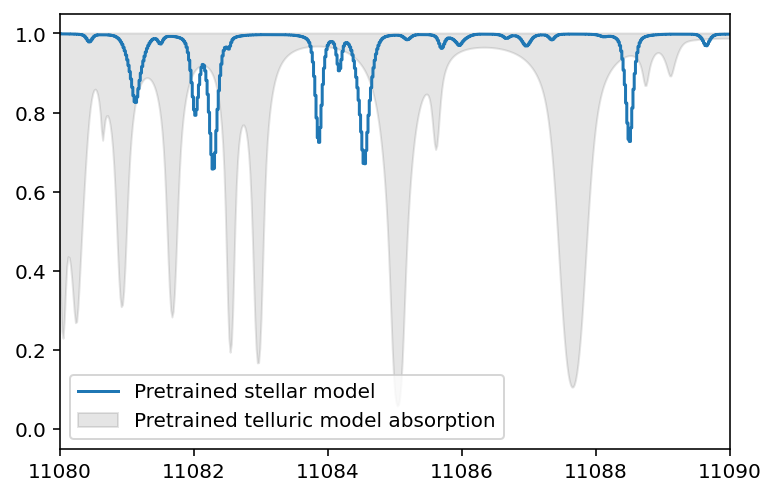

In [7]:
plt.step(wavelength_grid, stellar_flux, label='Pretrained stellar model')
plt.fill_between(wavelength_grid, telluric_transmission, 1.0,
                label='Pretrained telluric model absorption', alpha=0.1, color='k')
plt.xlim(11_080, 11_090)
plt.legend();

Voilá! We successfully read-in our pretrained models!